In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns #导入seaborn库，用于绘制更加美观的统计图形

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['font.family']=['Times New Roman', 'SimHei']
plt.rcParams['axes.unicode_minus'] = False #负号不识别问题 
sns.set_style('whitegrid') #设置白色风格
sns.set_palette('muted') #将当前 Seaborn 图表的默认调色板（color palette）设置为 "muted"（柔和）主题
#数据清洗
accidents = pd.read_csv(r'D:/python_demo/coding/data/accid1.csv', encoding='gbk') 
# errors='coerce' 遇到无效格式转换为NaT（时间类型却缺失值）避免转换时报错
accidents['accidenttime'] = pd.to_datetime(accidents['accidenttime'], errors='coerce')

accidents = accidents.dropna(subset=['accidenttime'])
#提取时间特征
accidents['hour'] = accidents['accidenttime'].dt.hour #从中提取小时信息
accidents['weekday'] = accidents['accidenttime'].dt.weekday #返回0-6数据0代表周一
accidents['month'] = accidents['accidenttime'].dt.month #存储1-12

accidents['is_weekday'] = accidents['weekday'].apply(lambda x: "周末" if x >= 5 else "工作日")

def is_peak_hour(hour):
    if hour <= 7 and hour >= 9:
        return '早高峰7-9点'
    elif 17 <= hour <= 19:
        return '晚高峰17-19点'
    else:
        return '非高峰段'
    
accidents['peak_hour'] = accidents['hour'].apply(is_peak_hour)

11

11

In [3]:
accidents.head()

,accidenttime,accidentaddr,driver1fault,driver1responsibility,driver2responsibility,sex1,platenumber1,carcolor1,sex2,platenumber2,...,clpp2,driver1license,driver2license,brith1,brith2,hour,weekday,month,is_weekday,peak_hour
0,2015-02-04 08:23:00,花溪大道北段,7、未按规定让行的,负全部责任,不负责任,1,贵AVG423,白色,1,贵A74653,...,新感觉,36455619349666600,366577000000000000,985082,199006,8,2,2,工作日,非高峰段
1,2015-02-04 08:40:00,花溪区孟关乡,3、倒车的,负全部责任,不负责任,1,贵AKC352,白色,1,贵A6156A,...,起亚牌,354664000000000000,364556000000000000,196904,199402,8,2,2,工作日,非高峰段
2,2015-02-04 07:20:00,白金大道,1、追尾的,负全部责任,不负责任,1,贵A24876,蓝,1,贵AN6491,...,银翔牌,366364000000000000,364558000000000000,196907,198508,7,2,2,工作日,非高峰段
3,2015-02-04 09:20:00,金阳,7、未按规定让行的,负全部责任,不负责任,1,贵A7287L,黑,0,贵A7088C,...,长安牌,366068000000000000,364557000000000000,197512,197906,9,2,2,工作日,非高峰段
4,2015-02-04 09:00:00,新华路,9、不符合前8款规定或者双方同时具有上述情形的,负同等责任,负同等责任,1,贵AU1522,白色,1,贵A68C55,...,海马牌,366577000000000000,364548000000000000,197209,197701,9,2,2,工作日,非高峰段


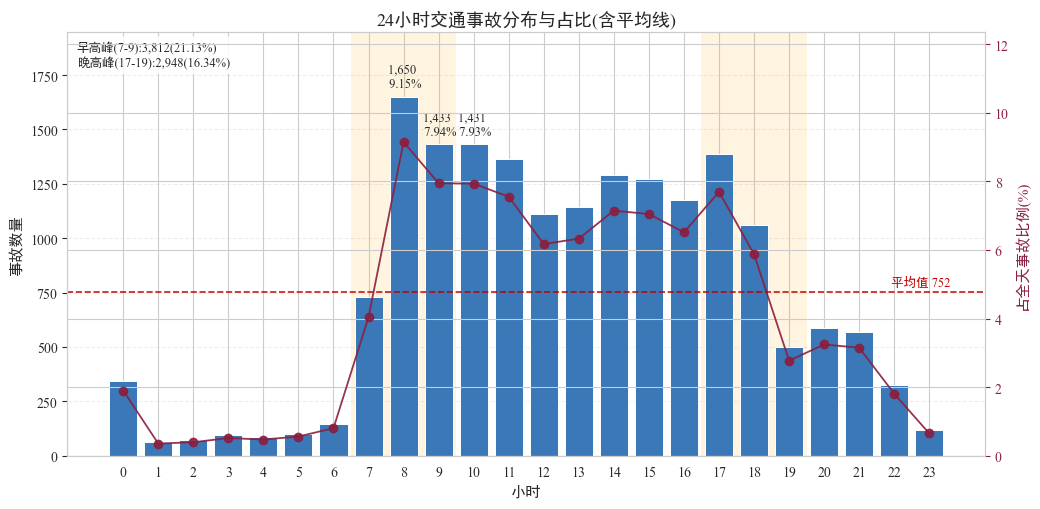

In [4]:
# 事故发生时段-按小时
import pandas as pd # 导入pandas库,用于数据分析和处理
import matplotlib.pyplot as plt # 导入matplotlib.pyplot,用于数据可视化(绘图)
import matplotlib as mpl # 导入matplotlib库,用于更复杂的绘图设置,如字体设置

# 全局设置
plt.rcParams["font.family"] = ["Times New Roman", "SimHei"] # 设置字体, 优先使用Times New Roman (英文), 其次使用SimHei(宋体,中文)
plt.rcParams['axes.unicode_minus'] = False # 解决matplotlib绘图时,负号'-'显示为方块的问题

base_color = '#3A78B7'
peak_span_color = '#FFA500'
line_color = '#8B1E3F'
mean_line_color = '#C00000'

# ===== 数据准备(两种统计口径任选其一) =====
#1)总量口径(与现有hour_df计算逻辑一致):
hour_df = accidents.groupby('hour').size().reset_index(name='count')#按小时分组统计事故数量,size()返回每

#2)(可选)按天平均口径:避免不同天数带来的偏差(如部分小时包含的天数更多),更适合企业对比分析
# accidents['date']= accidents['accidenttime'].dt.date #从事故时间中提取日期(年月日),新增'date'列
# daily_hour = accidents.groupby(['date','hour']).size().reset_index(name='cnt')#按日期和小时双重分组,
# hour_df = daily_hour.groupby('hour')['cnt'].mean().round(2).reset_index(name='count')#按小时分组计算日

# 确保数据按小时从小到大排序
hour_df = hour_df.sort_values('hour',ascending=True).reset_index(drop=True) #按"hour'列升序排序,reset_index(drop=True)重置索引

# ===== 配置:高峰时段窗口与颜色参数 =====
morning_peak=[7,8,9] #定义早高峰时段为7-9点
evening_peak=[17,18,19] #定义晚高峰时段为17-19点
peak_hours= set(morning_peak+evening_peak)# 合并早晚高峰时段,用集合去重(此处无重复,仅统一格式)

# 基础颜色:冷色系蓝色(用于柱状图)
# 高峰阴影颜色:橙色(用于标记高峰时段背景)
# 折线颜色:深红色(用于右轴占比折线)
# 均值线颜色:红色(用于标记平均事故数水平线)

# ===== 计算百分比与均值 =====
total= hour_df['count'].sum()#计算全天24小时的事故总数
pct=hour_df['count']/total* 100.0 # 计算每个小时的事故数占全天总数的百分比,存为pct
mean_val=hour_df['count'].mean()#计算24小时的平均事故数,作为参考基准

# ===== 开始绘图 =====
fig, ax=plt.subplots(figsize=(10.5,5.2))#创建画布和子图,设置画布大小为10.5x5.2英寸

# 绘制高峰时段阴影(x轴为小时整数,阴影范围向左右各扩展0.5以覆盖整小时区间)
# 早高峰阴影:覆盖6.5-9.5(即7-9点),颜色
# 晚高峰阴影:覆盖16.5-19.5(即17-19点),

ax.axvspan(6.5, 9.5, color=peak_span_color, alpha=0.12, lw=0)
ax.axvspan(16.5, 19.5, color=peak_span_color, alpha=0.12, lw=0)

#绘制柱状图(事故数量)
bars = ax.bar(
hour_df['hour'],#x轴数据:小时(0-23)
hour_df['count'],#y轴数据:每个小时的事故数量
color=base_color,#柱子颜色为base_color
edgecolor='white',#柱子边框为白色
linewidth=0.7 # 边框线宽0.7,增强清晰度

)

# 设置左轴标题与坐标轴标签
ax.set_title('24小时交通事故分布与占比(含平均线)',fontsize=13)#设置图表标题,字体大小13'
ax.set_xlabel('小时',fontsize=11)#设置x轴标签为“小时”,字体大小11
ax.set_ylabel('事故数量',fontsize=11)#设置左y轴标签为“事故数量”,字体大小11
ymax=hour_df['count'].max()#获取事故数量的最大值
ax.set_ylim(0,ymax* 1.18) #设置左y轴范围:从0到最大值的1.18倍

# 添加网格线(仅y轴,增强读数参考)
ax.grid(axis='y',linestyle='--',alpha=0.35)#仅在y轴添加虚线网格,透明度0.35

# 绘制均值虚线(标记24小时平均事故数)
ax.axhline(mean_val, color=mean_line_color, linestyle='--', lw=1.2, alpha=0.9)#绘制水平虚线,y值为mean_V
ax.text(
23.6,mean_val* 1.02,# 文本位置:x=23.6(接近右边缘),y=均值的1.02倍(略高于线)
f'平均值 {mean_val :.0f}',#文本内容:平均值加整数显示
color=mean_line_color, fontsize=9, ha='right', va='bottom'

# 文本颜色与均值线一致,字体9号,右对齐,底部

)

#创建右轴,绘制占比折线图
ax2=ax.twinx()#共享x轴,创建双y轴(右轴)
ax2.plot(
hour_df['hour'], pct,#x轴为小时,y轴为百分比数据pct
marker='o',linewidth=1.3,alpha=0.9,#折线带圆形标记,线宽1.3,透明度0.9
color=line_color #折线颜色为Line_color
)
ax2.set_ylabel('占全天事故比例(%)',fontsize=11,color=line_color)#设置右y轴标签,字体11号,颜色与折线一
ax2.tick_params(axis='y',colors=line_color)#右y轴刻度颜色与折线一致
ax2.set_ylim(0,pct.max()*1.35)#右y轴范围:从0到最大百分比的1.35倍,预留空间

# 在顶部标注事故数量Top3的小时(按数量排序)
def fmt_pct(n):
    return f"{n/total*100 :.2f}%" #定义百分比格式化函数:将数值n转换为占总数的百分比,保留2位小数
top3=hour_df.nlargest(3,'count')#筛选事故数量排名前三的小时数据
for _, r in top3.iterrows():#遍历Top3的每一行数据
    ax.text(
    r['hour'],r['count']*1.02,#文本位置:x为小时,y为该小时事故数的1.02倍(柱子顶部上方)
    f"{int(r['count']):,} \n {fmt_pct(r['count'])}",#文本内容:事故数(整数+千分位分隔)+换行+百分比
    ha='center', va='bottom',fontsize=9 #水平居中,垂直底部对齐,字体9号
    )
# 在图表角落标注早晚高峰的事故总数及占比
morning_sum = hour_df.loc[hour_df['hour'].isin(morning_peak),'count'].sum()#计算早高峰时段(7-9点)的事
evening_sum = hour_df.loc[hour_df['hour'].isin(evening_peak),'count'].sum()#计算晚高峰时段(17-19点)的
ax.text(
0.01,0.98,#文本位置:相对于子图的比例坐标(左边缘1%,上边缘2%)
f"早高峰(7-9):{morning_sum:,}({fmt_pct(morning_sum)})\n" #早高峰数据:总数(千分位)+占比
f"晚高峰(17-19):{evening_sum:,}({fmt_pct(evening_sum)})",#晚高峰数据:同上
transform=ax.transAxes, ha='left', va='top',fontsize=9,#使用相对坐标,左对齐,顶部对齐,字体9号
bbox=dict(boxstyle='round,pad=0.35', facecolor='white', alpha =.85, lw=0)#添加白色半透明背景框,圆角,
)
ax.set_xticks(range(0, 24, 1)) #设置X轴刻度, 从0到23, 每隔2个显示一个
plt.tight_layout() #自动调整子图参数, 使之填充整个图像区域, 避免标签重叠
plt.show() #显示图表



    hour  avg_per_hour
8      8         14.35
9      9         12.46
10    10         12.44


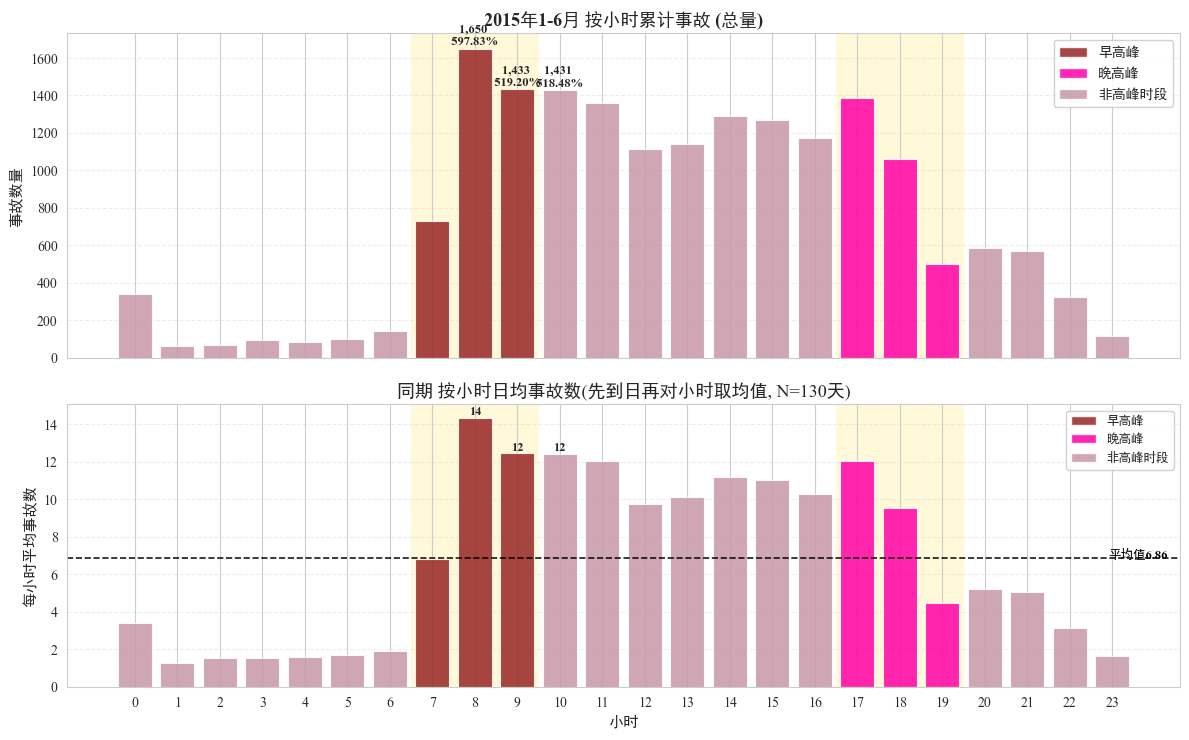

In [5]:
# 事故发生时段-按小时
import pandas as pd # 导入pandas库,用于数据分析和处理
import matplotlib.pyplot as plt # 导入matplotlib.pyplot,用于数据可视化(绘图)
import matplotlib as mpl # 导入matplotlib库,用于更复杂的绘图设置,如字体设置
from matplotlib.patches import Patch #导入Patch类，用于定义图例元素

# 全局设置
plt.rcParams["font.family"] = ["Times New Roman", "SimHei"] # 设置字体, 优先使用Times New Roman (英文), 其次使用SimHei(宋体,中文)
plt.rcParams['axes.unicode_minus'] = False # 解决matplotlib绘图时,负号'-'显示为方块的问题

accidents['accidenttime'] = pd.to_datetime(accidents['accidenttime'], errors='coerce')
accidents = accidents.dropna(subset=['accidenttime'])
accidents['hour'] = accidents['accidenttime'].dt.hour
accidents['date'] = accidents['accidenttime'].dt.date

hour_total=(
    accidents.groupby('hour').size()
    .reindex(range(24), fill_value=0) #确保0-23小时都有值
    .reset_index(name='count')
    .rename(columns={'index':'hour'}) 
)
daily_hour = (
    accidents.groupby(['date', 'hour'])
    .size().reset_index(name='cnt')
)
N_days = daily_hour['date'].nunique() #计算总天数
hour_mean = (
    daily_hour.groupby('hour')['cnt'].mean().reindex(range(24), fill_value=0.0).round(2)
    .reset_index(name='avg_per_hour')
    .rename(columns={'index':'hour'})
)
morning_peak = [7, 8, 9]
evening_peak = [17, 18, 19]
morning_color = "#972525" #
evening_color = "#FF00A6" #晚高峰显示
normal_color = "#C797A6" #非高峰颜色
mean_line_color = "#000000" #均值线显示

#定义函数
def get_bar_color(hour):
    """"根据小时判断所属时段，返回对应的柱子颜色"""
    if hour in morning_peak:
        return morning_color
    elif hour in evening_peak:
        return evening_color
    else: #非高峰时段
        return normal_color
    
global_avg = hour_mean['avg_per_hour'].mean()

fig, (ax1, ax2) = plt.subplots(
    nrows=2, ncols=1, #创建两行一列的子图布局
    figsize=(12, 7.5), #画布大小为7.5 * 12英寸
    sharex=True, #两张图共享x，确保横轴刻度一致
    gridspec_kw={'height_ratios':[1.15, 1.0]} #上下图高度比例为1.15：1.0上图略高随意自己太哦
)
#上图：累计和
#绘制透明区域背景
ax1.axvspan(6.5, 9.5, color='#FFD700', alpha=0.15, lw=0, zorder=0)#zorder图层优先级为0在底层
ax1.axvspan(16.5, 19.5, color='#FFD700', alpha=0.15, lw=0, zorder=0)#zorder图层优先级为0在底层
color1 = [get_bar_color(h) for h in hour_total['hour']]
bars1 = ax1.bar(
    hour_total['hour'],
    hour_total['count'],
    color=color1,
    edgecolor='white',
    linewidth=0.8,
    alpha=0.85,
    zorder=2
)
ax1.set_title('2015年1-6月 按小时累计事故 (总量)', fontsize=13, fontweight='bold')
ax1.set_ylabel('事故数量', fontsize=11) #y轴标签,累计事故数量
ax1.grid(axis='y', linestyle='--', alpha=0.35)
#标注上图事故数量排名前三小时突出关键时段
top3_total=hour_total.nlargest(3, 'count')
# print(top3_total)
sum_total = hour_total['hour'].sum()
for _, r in  top3_total.iterrows():
    pct = r['count'] / sum_total * 100 if sum_total > 0 else 0
    ax1.text(
        r['hour'], r['count']*1.02,
        f"{int(r['count']):,} \n {pct:.2f}% \n",
        ha='center', va='center', fontsize=9, fontweight='bold'
    )
legend_elementsl = [
    Patch(facecolor=morning_color, alpha=0.85, label='早高峰'),
    Patch(facecolor=evening_color, alpha=0.85, label='晚高峰'),
    Patch(facecolor=normal_color, alpha=0.85, label='非高峰时段'),
]
ax1.legend(handles=legend_elementsl, loc=1, framealpha=0.9)#framealpha=0.9透明底为0.9

ax2.axvspan(6.5, 9.5, color='#FFD700', alpha=0.15, lw=0, zorder=0)#zorder图层优先级为0在底层
ax2.axvspan(16.5, 19.5, color='#FFD700', alpha=0.15, lw=0, zorder=0)#zorder图层优先级为0在底层
color2 = [get_bar_color(h) for h in hour_total['hour']]
bars2 = ax2.bar(
    hour_total['hour'],
    hour_mean['avg_per_hour'], #每小时平均事故数
    color=color2,
    edgecolor='white',
    linewidth=0.8,
    alpha=0.85,
    zorder=2
)
#绘制日均事故数的平均虚线
ax2.axhline(
    global_avg,
    color=mean_line_color,
    linestyle='--',
    lw=1.2, alpha=0.9
)
ax2.text(
    23.6,
    global_avg*1.02,
    f'平均值{global_avg:.2f}',
    color=mean_line_color, fontsize=9, ha='center', va='center', fontweight='bold'
)
ax2.set_title(
    f'同期 按小时日均事故数(先到日再对小时取均值, N={N_days}天)',
    fontsize=13,
)
ax2.set_xlabel('小时', fontsize=11)
ax2.set_ylabel('每小时平均事故数', fontsize=11)
ax2.grid(axis='y', linestyle='--', alpha=0.35)

top3_mean = hour_mean.nlargest(3, 'avg_per_hour')
print(top3_mean)
for _, r in top3_mean.iterrows():
    ax2.text(
        r['hour'], r['avg_per_hour']*1.02,
        f"{int(r['avg_per_hour']):,}",
        ha='center', va='center', fontsize=9, fontweight='bold'
    )
legend_elements2 = [
    Patch(facecolor=morning_color, alpha=0.85, label='早高峰'),
    Patch(facecolor=evening_color, alpha=0.85, label='晚高峰'),
    Patch(facecolor=normal_color, alpha=0.85, label='非高峰时段'),
]
ax2.legend(handles=legend_elements2, loc=1, framealpha=0.9 ,fontsize=9)#framealpha=0.9透明底为0.9
ax2.set_xticks(range(0, 24, 1))
plt.tight_layout()
plt.show()


Text(0, 1, '工作日:13081(72.51%) 日均139.2 \n周末:4960(27.49%) 日均137.8')

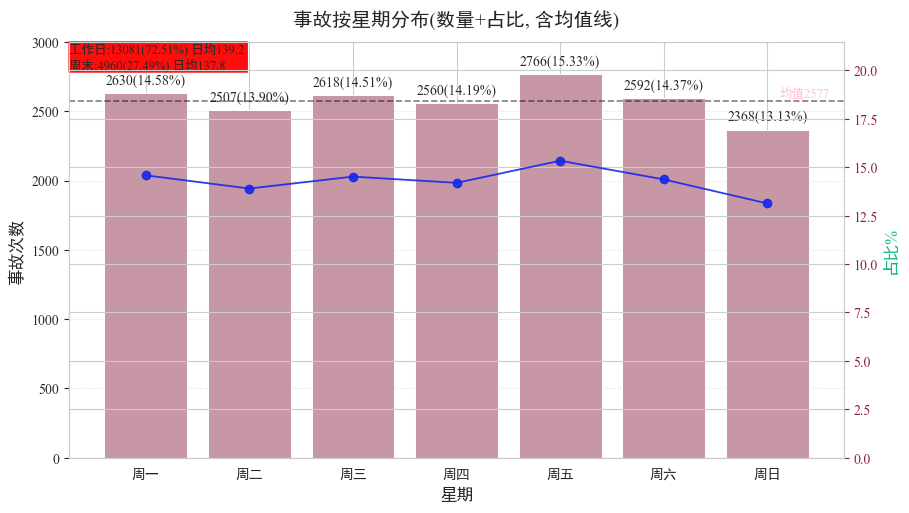

In [6]:
import matplotlib.pyplot as plt # 导入matplotlib.pyplot,用于数据可视化(绘图)
import matplotlib as mpl # 导入matplotlib库,用于更复杂的绘图设置,如字体设置
from matplotlib.patches import Patch #导入Patch类，用于定义图例元素

weekday_counts = accidents['weekday'].value_counts().sort_index() #.value_counts()生成频数
weekday_labels = ['周一','周二','周三','周四','周五','周六', '周日']
x = np.arange(7)
y = weekday_counts.values
total = y.sum()
pct = y/total * 100 
colors = ['#9cdcfe'] * 5 + ['#c586b6'] * 2
fig, ax = plt.subplots(figsize=(10, 5.4))

bars = ax.bar(
    x, 
    y,
    color=color1,
    edgecolor='white',
    linewidth=0.7,
)
#设置左轴标题和坐标轴标签
ax.set_title('事故按星期分布(数量+占比, 含均值线)', fontsize=14, pad=12) #pd为距离顶部距离
ax.set_xlabel('星期', fontsize=12)
ax.set_ylabel('事故次数', fontsize=12)
ax.set_xticks(x)
ax.set_ylim(0, 3000)
ax.set_xticklabels(weekday_labels) #将x轴刻度替换为星期名
ax.grid(axis='y', linestyle='--', alpha=0.35) #添加y轴虚线网络，透明度为0.35

mean_val = y.mean()
ax.axhline( #绘制水平线
    mean_val, #水平线y值：平均值
    color='black',
    ls='--',
    lw=1.2,
    alpha=0.5
)
ax.text(
    6.6, mean_val * 1,
    f'均值{mean_val:.0f}', #平均文本内容取整数
    color='pink',ha='right', va='bottom', fontsize=9
)
ax2 = ax.twinx()
ax2.plot(
    x,
    pct,
    color='#1429ed',
    marker='o', #数据点标记：园形
    lw=1.3, alpha=.9
)
ax2.set_ylabel('占比%', fontsize=12, color='#0dbc79')
ax2.tick_params(axis='y', colors='#8B1E3F') #又y轴颜色和折现一致
ax2.set_ylim(0, pct.max()*1.4)

ymax = y.max()
for xi, yi, pi in zip(x, y, pct):
    ax.text(
        xi, yi + ymax*0.015,
        f'{int(yi)}({pi:.2f}%)',
        ha='center', va='bottom',
    )

accidents['date'] = accidents['accidenttime'].dt.date
# accidents.head()
by_day = accidents.groupby(['date', 'weekday']).size().reset_index(name='cnt')
# print(accidents.groupby(['date', 'weekday']).size())
# print(accidents.loc[:, ['date', 'weekday']])
wk_avg = by_day.loc[by_day['weekday'].isin(range(5)), 'cnt'].mean()
we_avg = by_day.loc[by_day['weekday'].isin([5, 6]), 'cnt'].mean()
wk_sum = y[:5].sum()
we_sum = y[5:].sum()
ax.text(
    0, 1, #相对子图的比例坐标(左边缘1.5%， 上边缘2%)
    f'工作日:{wk_sum}({wk_sum/total*100:.2f}%) 日均{wk_avg:.1f} \n'
    f'周末:{we_sum}({we_sum/total*100:.2f}%) 日均{we_avg:.1f}', #周末数据#周末数据

    transform=ax.transAxes, ha='left', va='top', fontsize=9, #transform=ax.transAxes告诉其适用相对坐标器不使用坐标器
     bbox=dict(boxstyle='round,pad=0.05', facecolor='red', alpha=.95, lw=0) #ax.transAxes相对坐标左对其
)

正在读取数据


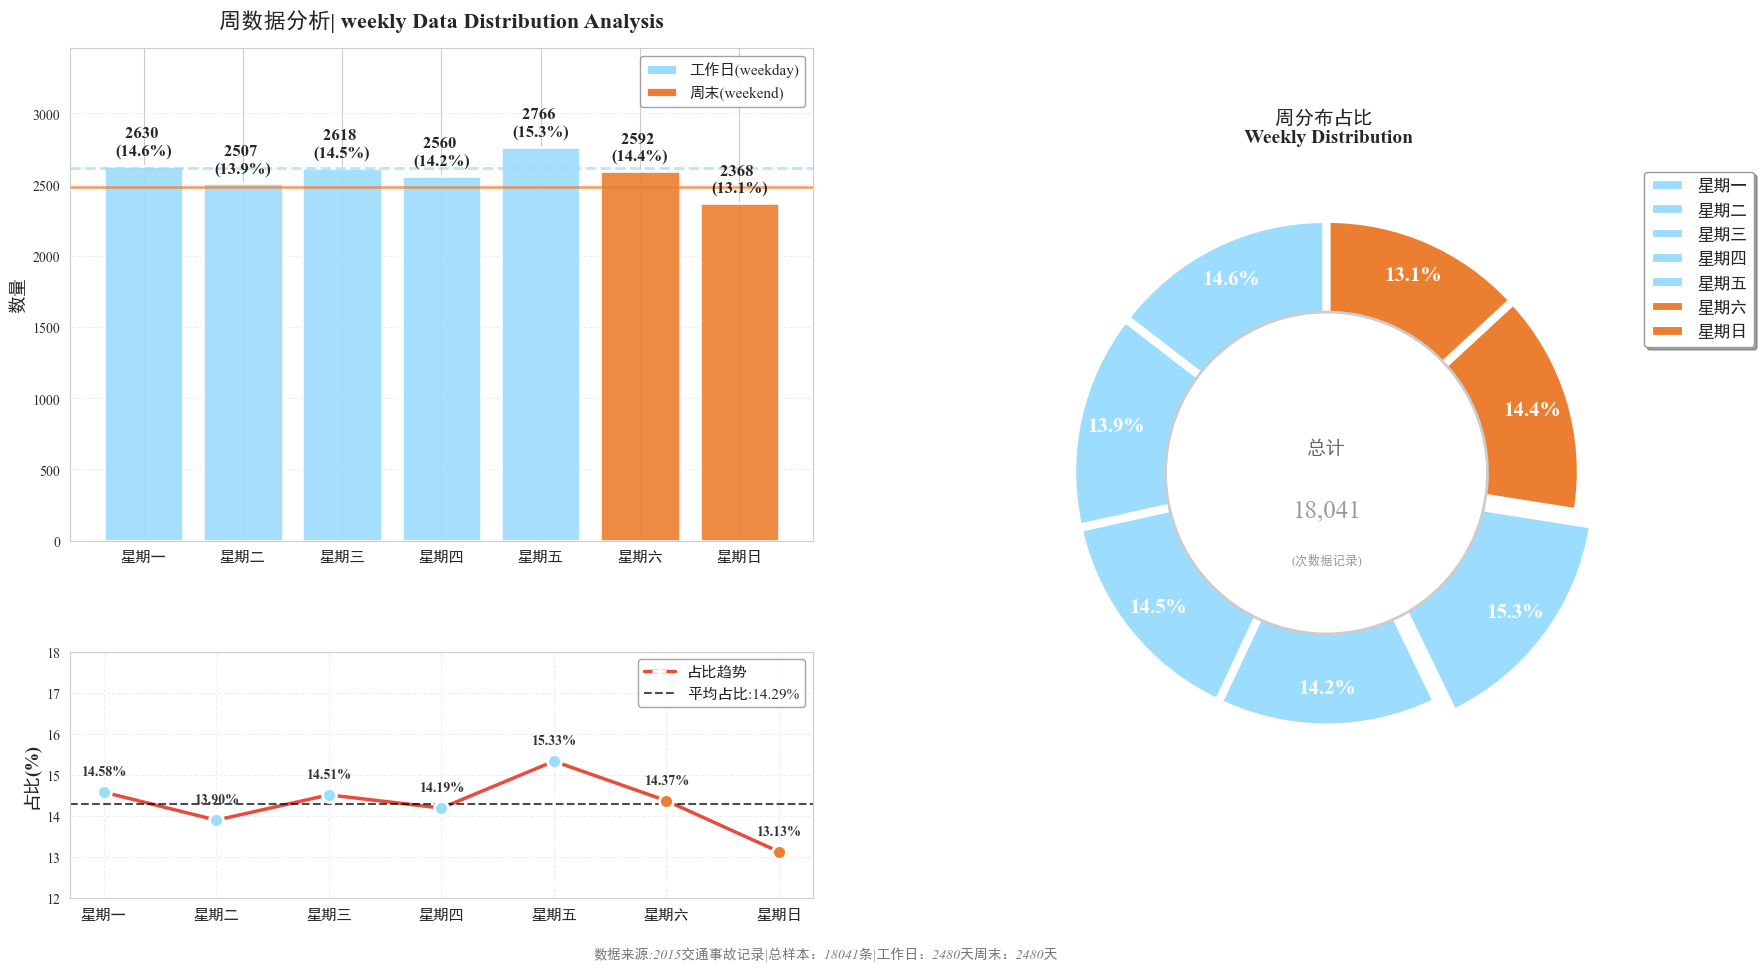

In [7]:
import matplotlib.pyplot as plt # 导入matplotlib.pyplot,用于数据可视化(绘图)
from matplotlib import gridspec,  patches #gridspec导入创建复杂子图布局，patches自定义图例元素

import pandas as pd
import numpy as np

plt.rcParams["font.family"] = ["Times New Roman", "SimHei"] # 设置字体, 优先使用Times New Roman (英文), 其次使用SimHei(宋体,中文)
plt.rcParams['axes.unicode_minus'] = False # 解决matplotlib绘图时,负号'-'显示为方块的问题
print('正在读取数据')
try:
    accidents = pd.read_csv(r'D:/python_demo/coding/data/accid1.csv', encoding='gbk')
except:
    print('gbk编码方式不兼容换cp1252')
    accidents = pd.read_csv(r'D:/python_demo/coding/data/accid1.csv', encoding='cp1252')
accidents.head()

#数据处理
accidents['accidenttime'] = pd.to_datetime(accidents['accidenttime'], errors='coerce')
accidents = accidents.dropna(subset=['accidenttime'])

accidents['weekday'] = accidents['accidenttime'].dt.weekday
accidents['weekday_name'] = accidents['weekday'].map({
    0:'星期一',1:'星期二',2:'星期三',3:'星期四',4:'星期五',5:'星期六',6:'星期日'
}
)
accidents['is_weekend'] = accidents['weekday'].apply(
    lambda x: '周末' if x >= 5 else "工作日"
)
weekday_stats = accidents.groupby('weekday').agg({
    'accidenttime':'count'
}).reset_index()
weekday_stats.columns = ['weekday', 'count']
weekday_stats = weekday_stats.sort_values('weekday')
weekday_stats['星期'] = weekday_stats['weekday'].map({
    0:'星期一',1:'星期二',2:'星期三',3:'星期四',4:'星期五',5:'星期六',6:'星期日'
}
)
weekday_stats
total = weekday_stats['count'].sum()
weekday_stats['percentage'] = weekday_stats['count'] / total * 100
weekday_stats['type'] = weekday_stats['weekday'].apply(
    lambda x: '周末(weekend)' if x >= 5 else '工作日(weekday)'
)
weekday_avg = weekday_stats[weekday_stats['weekday'] < 5] ['count'].mean()
weekend_avg = weekday_stats[weekday_stats['weekday'] >= 5] ['count'].mean()
fig = plt.figure(figsize=(18, 10))
gs = gridspec.GridSpec(2, 2, figure=fig,
              height_ratios=[2, 1],
              width_ratios=[1.2, 1],
              hspace=0.3, 
              wspace=0.3,
              left=0.08, right=0.95, top=0.93, bottom=0.08)
color_weekday = '#9cdcfe' 
color_weekend = '#ec7e31' 

#左上柱状图
ax1 = fig.add_subplot(gs[0, 0]) #定位到1行1列
x_pos = np.arange(len(weekday_stats))

colors = [color_weekday if wd<5 else color_weekend for wd in weekday_stats['weekday']]
#绘制柱状图
bars = ax1.bar(x_pos, weekday_stats['count'],
               color=colors,
               edgecolor='white',
               linewidth=2,
               alpha=0.9)
ax1.axhline(y=weekday_avg, color=color_weekday, linestyle='--', linewidth=2, alpha=.7, label=f'工作日均值:{int(weekday_avg)}')
#周末平均线
ax1.axhline(y=weekend_avg, color=color_weekend, linewidth=2, alpha=0.7, label=f'周末均值{int(weekend_avg)}')
#在柱子上添加百分比标注
for i, (bar, row) in enumerate(zip(bars, weekday_stats.itertuples())):
    height = bar.get_height() #获取柱子高度
    ax1.text(
        bar.get_x() + bar.get_width()/2,
        height + 50,
        f'{int(height)} \n'f'({row.percentage:.1f}%)',
        ha='center', va='bottom', fontsize=12, fontweight='bold'
    )
    # ax1.text(bar.get_x() + bar.get_width()/2,
    #          height + 120,
    #          f'({row.percentage:.1f}%)',
    #          ha='center', va='bottom', fontsize=12, color='#555')
ax1.set_title('周数据分析| weekly Data Distribution Analysis',
              fontsize=16, fontweight='bold', pad=15)
ax1.set_ylabel('数量', fontsize=13, fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(weekday_stats['星期'], fontsize=11)
ax1.set_ylim(0, weekday_stats['count'].max() * 1.25)
ax1.grid(axis='y', ls='--', alpha=0.3)
legend_elements = [
    patches.Patch(facecolor=color_weekday, edgecolor='white', label='工作日(weekday)', linewidth=2),
    patches.Patch(facecolor=color_weekend, edgecolor='white', label='周末(weekend)', linewidth=2)
]
ax1.legend(handles=legend_elements, loc=1, fontsize=11, framealpha=0.9, edgecolor='#999')

ax2 = fig.add_subplot(gs[1, 0])
line_colors = [color_weekday if wd<5 else color_weekend for wd in weekday_stats['weekday']]

ax2.plot(
    x_pos, weekday_stats['percentage'],
    marker='+', markersize=10, linewidth=2.5, color='#E74C3C',
    markerfacecolor='#E74C3C', #标记填充色
    markeredgecolor='white', #标记边框色
    markeredgewidth=2,
    label='占比趋势'
)
for i, (x, y, color) in enumerate(zip(x_pos, weekday_stats['percentage'], colors)):
    ax2.plot(
        x, y, 'o',
        markersize=10,color=color, markeredgecolor='white',markeredgewidth=2, zorder=3,
    )
avg_percentage = weekday_stats['percentage'].mean()
ax2.axhline(
    avg_percentage,
    color='#000000',
    linestyle='--',
    linewidth=1.5,
    alpha=0.7,
    label=f'平均占比:{avg_percentage:.2f}%'
)
for x, y in zip(x_pos, weekday_stats['percentage']):
    ax2.annotate(  #标注内容：百分比
        f'{y:.2f}%',
        xy=(x, y),
        xytext=(0, 10),
        textcoords='offset points', #偏移点， 偏移方式：相对点偏移
        ha='center', va='bottom',
        fontsize=10,
        fontweight='bold',
        color='#333'
    )
#设置标题和标签、
ax2.set_ylabel('占比(%)', fontsize=13, fontweight='bold')
ax2.set_xlabel('', fontsize=13, fontweight='bold')
ax2.set_xticks(x_pos) #x轴刻度位置
ax2.set_xticklabels(weekday_stats['星期'], fontsize=11) #x轴刻度标签
ax2.set_ylim(12, 18)
ax2.grid(True, linestyle='--', alpha=0.3)
ax2.legend(loc=1, fontsize=11, framealpha=0.9, edgecolor='#999')

#右侧：环形饼图
ax3 = fig.add_subplot(gs[:, 1])
pie_colors = [color_weekday if wd < 5 else color_weekend for wd in weekday_stats['weekday']]
#设置各部分的分离距离
explode = [0.1 if wd== 4 else 0.02 for wd in weekday_stats['weekday']]

wedges, texts, autotexts = ax3.pie(
    weekday_stats['count'],
    labels=None,
    autopct='%1.1f%%', #自动计算并显示百分比
    startangle=90, #从正上方开始绘制
    colors=pie_colors, 
    explode=explode, #应用分离设置
    wedgeprops={'edgecolor':'white', 'linewidth':3}, #扇形边框：白色，线宽为3
    textprops={'fontsize':15, 'fontweight':'bold', 'color':'white'}, #百分比文本样式
    pctdistance=0.85 #百分比文本样式距离圆心的相对位置
)
centre_circle = plt.Circle((0, 0), 0.65,  #圆心和半径
                           fc='white', linewidth=2, edgecolor='#CCC')
ax3.add_artist(centre_circle) #将白色圆圈添加到子图
ax3.text(0, 0.1, '总计', ha='center', va='center', color='#666', fontsize=14, fontweight='bold')
ax3.text(0, -0.35, '(次数据记录)',ha='center',fontsize=9, va='center', color='#999')
ax3.text(0, -0.15, f'{total:,}',ha='center', va='center', color='#999',fontsize=18,)
#添加图列
lengend_labels = [f'{row.星期}' for _, row in weekday_stats.iterrows()] #每列
ax3.legend(
    wedges, lengend_labels,
    loc=2, 
    bbox_to_anchor=(1, 0, 0.5, 1), #调整图例位置
    fontsize=12,
    title_fontsize=13,
    frameon=True, #显示边框
    fancybox=True, #圆角边框
    shadow=True, #阴影效果
    edgecolor='#999'
)
ax3.set_title('周分布占比 \n Weekly Distribution',
              fontsize=14, fontweight='bold', pad=15)
#添加页脚说明
note_text = (f'数据来源:2015交通事故记录|'f'总样本：{total}条|' f'工作日：{weekend_avg:.0f}天'f'周末：{weekend_avg:.0f}天')
fig.text(0.5, 0.02, note_text, ha='center', fontsize=10, color='#777', style='italic') #style斜体灰色小子

plt.show()



Text(0, -0.3, '事故数\n18,036')

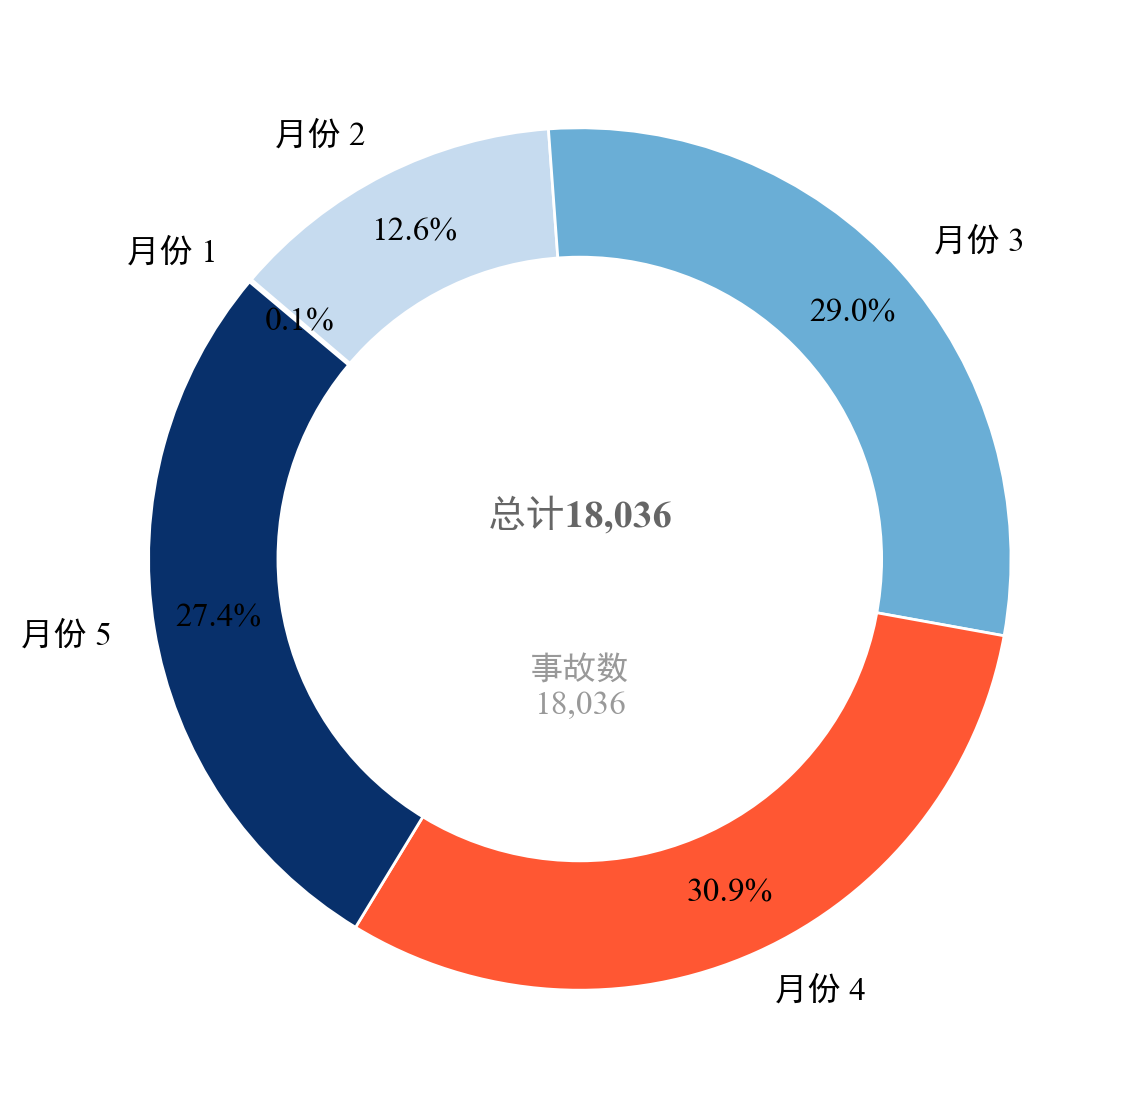

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams["font.family"] = ["Times New Roman", "SimHei"] # 设置字体, 优先使用Times New Roman (英文), 其次使用SimHei(宋体,中文)
plt.rcParams['axes.unicode_minus'] = False # 解决matplotlib绘图时,负号'-'显示为方块的问题
month_df = pd.DataFrame({
    'month': np.arange(1, 6),
    'count': [20, 2276, 5232, 5565, 4943]
})

#计算关键统计值
total = month_df['count'].sum()
peak_idx = month_df['count'].idxmax()
peak_month = month_df.loc[peak_idx, 'month']
peak_value = month_df.loc[peak_idx, 'count']
peak_ratio = peak_value / total * 100

#颜色配置
base_cmap = mpl.colormaps.get_cmap('Blues') #选择Blues颜色映射
colors = [base_cmap(i/(len(month_df)-1)) for i in range(len(month_df))]
colors[peak_idx] = '#FF5733' #高亮峰值颜色
fig, ax = plt.subplots(figsize=(7, 7), dpi=200)
#绘制饼图
wedges, texts, autotexts = ax.pie(
    month_df['count'],
    labels=[f'月份 {m}' for m in month_df['month']],
    autopct='%1.1f%%', #显示百分比, 自动格式化为1位小数
    startangle=140, #起始角度
    colors=colors,
    counterclock=False, #顺时针方向
    pctdistance=0.85, #百分比标签距离圆心的距离
    labeldistance=1.1, #标签距离圆心的距离
    textprops={'fontsize': 12, 'color': 'black'}
)
centre_circle = plt.Circle((0, 0), 0.70, fc='white') #添加白色圆圈以创建环形图
ax.add_artist(centre_circle)
ax.text(0, 0.1, f'总计{total:,}', ha='center', va='center', color='#666', fontsize=14, fontweight='bold', linespacing=1.2) #linespacing行间距
ax.text(0, -0.3, f'事故数\n{total:,}', ha='center', va='center', color='#999', fontsize=12)

  region  cnt
9   花溪大道  230
8     乌当  236
7     金阳  259
6    西二环  267
5     三桥  288
4     小河  313
3   北京西路  320
2     花溪  322
1    白云区  454
0    花果园  480


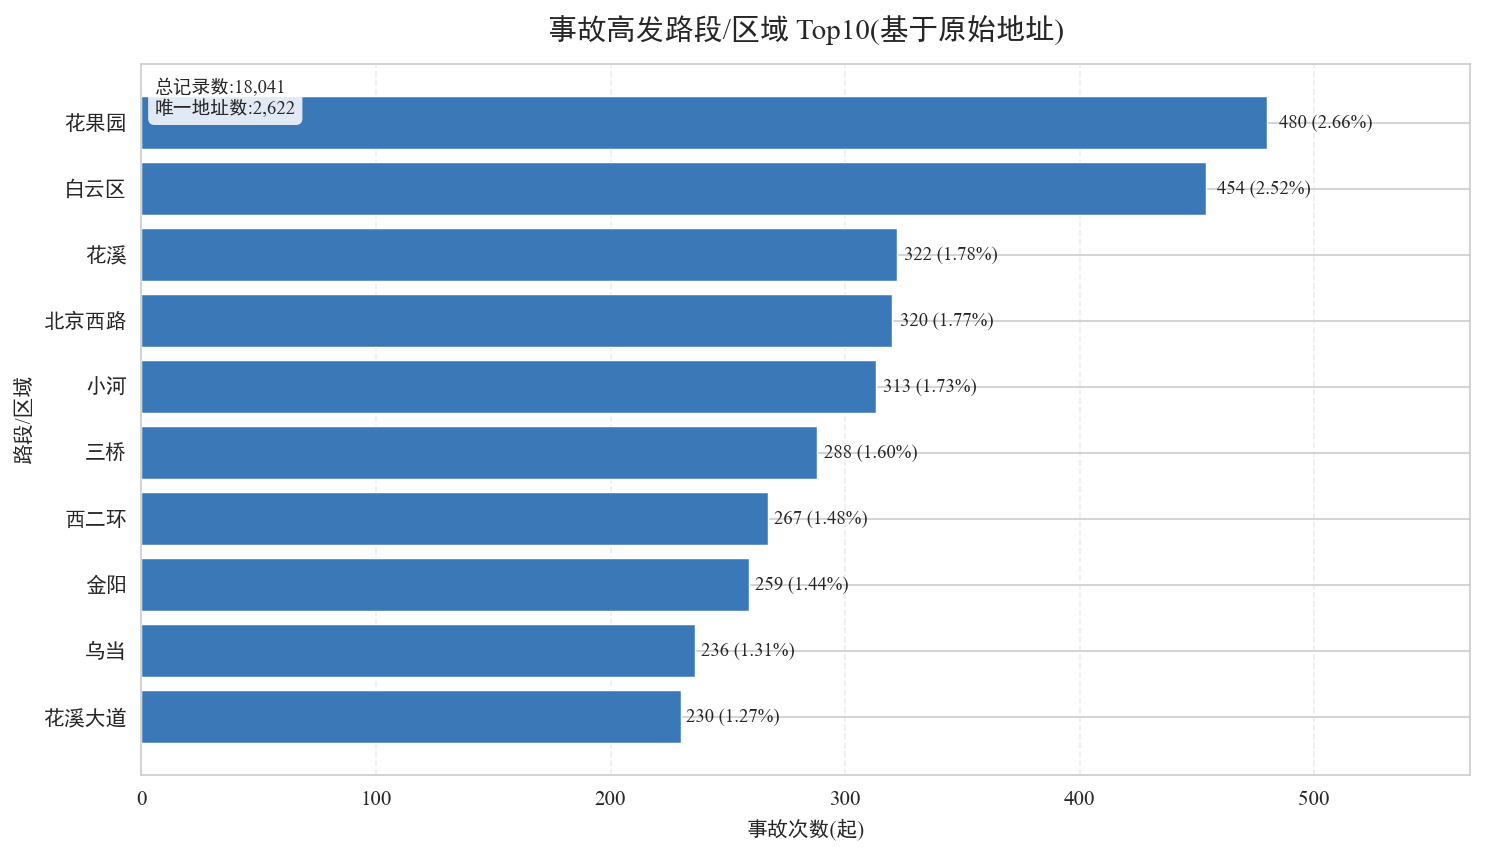

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotx
import matplotlib as mpl
from textwrap import shorten #用于文本缩略显示
addr_series = accidents['accidentaddr'].astype(str).fillna('未知地点') #将地址列表转换为字符串，缺失值转换为未知
top10 = (
    addr_series.value_counts() #计算地址频次
    .nlargest(10) #选取前10
    .reset_index() #重置索引
    .rename(columns={'accidentaddr':'region', 'count':'cnt'}) #重命名列
)
t10 = top10.sort_values('cnt')
print(t10)
plt.rcParams['figure.dpi' ] = 150

# ===== 2)绘制水平条形图展示Top10高发路段/区域 =====
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei','Arial'] #设置字体:优先黑体,微软雅黑,确保中文显示
# 设置图像的分辨率为150dpi,平衡清晰度大小
plt.rcParams['axes.unicode_minus'] = False

fig, ax=plt.subplots(figsize=(10,5.8))#创建画布和子图,大小为10x5.8英寸

# 处理过长的地址标签:超过最大长度时截断并添加省略号,避免标签挤压
max_len= 18 #最大允许的标签长度(字符数)
labels = [shorten(s, width=max_len, placeholder='_') for s in t10['region']] # 对每个地址应用截断处理

# 绘制水平条形图
bars = ax.barh(
labels,#y轴数据:处理后的地址标签(水平条形图的y轴为类别)
t10['cnt'],#x轴数据:每个地址的事故次数
color='#3A78B7',
edgecolor='white',#条形边框为白色(增强区分度)
linewidth=0.7 # 边框线宽0.7

# 解决坐标轴负号显示异常问题

# 条形颜色:冷蓝色

)

# 设置图表标题和坐标轴标签
ax.set_title('事故高发路段/区域 Top10(基于原始地址)',fontsize=14,pad=12)#标题:明确展示内容,字体14号,与顶部问距1
ax.set_xlabel('事故次数(起)')#x轴标签:事故次数(单位:起)
ax.set_ylabel('路段/区域')#y轴标签:路段或区域名称

# 在条形末端标注具体事故次数与占比
total=addr_series.shape[0] #计算总事故记录数(用于计算占比)
for y, (name, cnt) in enumerate(zip(t10['region'],t10['cnt'])):#遍历每个地址及其y轴索引

    ax.text(
    cnt *1.01,y,#文本位置:x为事故数的1.01倍(条形右侧),y为条形对应的y轴索引
    f'{cnt} ({cnt/total*100 :.2f}%)',#文本内容:事故数+占总事故数的百分比(保留2位小数)
    va='center',fontsize=9 #垂直居中对齐,字体9号
    )

# 网格线与x轴范围优化
ax.grid(axis='x', linestyle='--',alpha=0.35) #添加x轴虚线网格(辅助读数),透明度0.35
xmin, xmax=0, top10['cnt'].max()*1.18 #x轴范围:从0到最大事故数的1.18倍(预留空间)
ax.set_xlim(xmin, xmax) #设置x轴范围

# 在图表角落添加数据说明:总记录数与唯一地址数
ax.text(
0.01,0.98,#文本位置:相对于子图的比例坐标(左边缘1%,上边缘2%)
f'总记录数:{total:,}\n唯一地址数:{addr_series.nunique():,}',#文本内容:总记录数(前千分位)+换行+唯一地址数(去
transform=ax.transAxes, ha='left', va='top', fontsize=9,#使用相对坐标,左对齐,顶部对齐,字体9号
bbox=dict(boxstyle='round,pad=0.35', facecolor='white', alpha =.85, lw=0) #添加白色半透明背景框 圆角,内边距0.35

)

plt.tight_layout()#自动调整布局,避免元素重叠
plt.show()# 显示图表

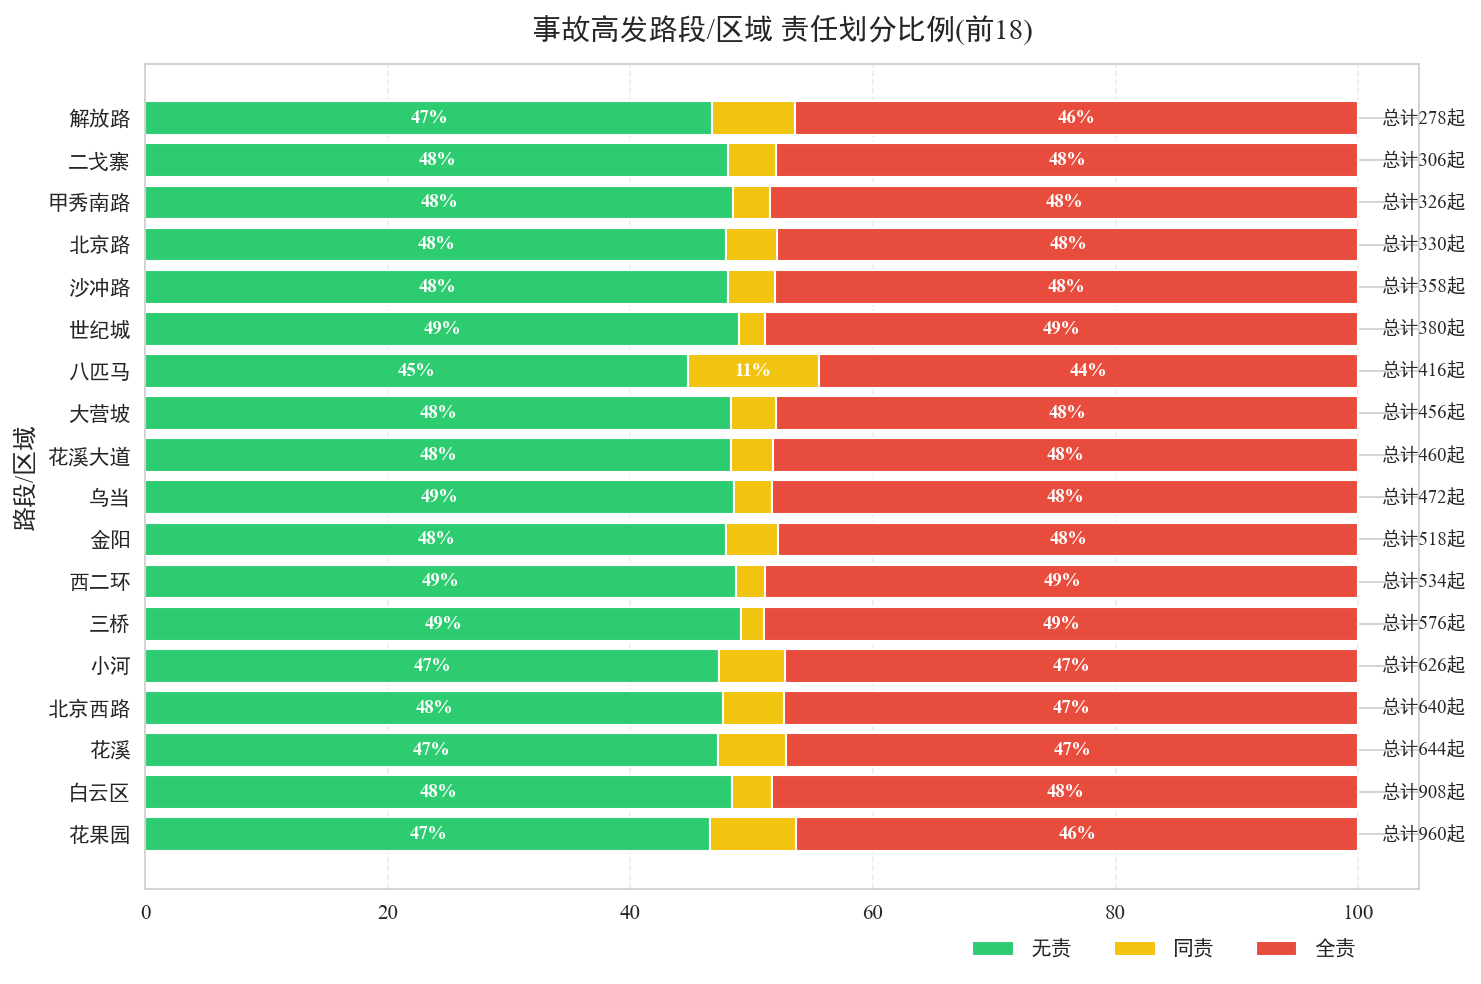

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
region_top10 = accidents['accidentaddr'].astype(str).value_counts().head(18)
top_regions = region_top10.index.tolist()
df = accidents[['accidentaddr' ,'driver1responsibility', 'driver2responsibility']].copy()
df = df.assign(accidentaddr=df['accidentaddr'].astype(str))#确保地址为字符串类型
# print(df.head())
party_long = pd.concat([
    df[['accidentaddr', 'driver1responsibility']].rename(columns={'driver1responsibility':'resp'}),
    #处理驾驶员2的责任则人类命名为resp
    df[['accidentaddr', 'driver2responsibility']].rename(columns={'driver2responsibility':'resp'})
], axis=0, ignore_index=True) #纵向合并两部分数据
party_long = party_long[party_long['accidentaddr'].isin(top_regions)].copy() #筛选出top10地址的数据
MAP = {
    '负全部责任':'全责',
    '负同等责任':'同责',
    '不负责任':'无责',
}
party_long['resp'] = party_long['resp'].map(MAP).fillna('其他') #映射责任类别,缺失值填充为未知
party_long = party_long[party_long['resp'] != '其他']
ct = (party_long
      .groupby(['accidentaddr', 'resp'])
      .size()
      .unstack(fill_value=0) #将责任类别展开为列,缺失值填充为0
)
resp_order = ['全责', '同责', '无责']
for col in resp_order:
    if col not in ct.columns:
        ct[col] = 0
ct = ct[resp_order] #按指定顺序排序
ct = ct.reindex(top_regions) #确保地址顺序与top10一致
ct_pct = (ct.div(ct.sum(axis=1), axis=0) * 100).round(2) #计算百分比

fig, ax = plt.subplots(figsize=(10, 7))
colors = {
    '全责': '#E74C3C',  # 红色
    '同责': '#F1C40F',  # 黄色
    '无责': '#2ECC71'   # 绿色
}
resp_order = ['无责', '同责', '全责'] #定义责任类别顺序
left = np.zeros(len(ct_pct)) #初始化左侧位置为0

for k in resp_order:
    ax.barh(
        ct_pct.index, #x轴数据:地址标签
        ct_pct[k], #y轴数据:百分比
        left=left,
        color=colors[k],
        edgecolor='white',
        label=k #图例标签，负责的类型名称
    )
    left += ct_pct[k].values #更新下一个条形的起始位置
for i, region in enumerate(ct_pct.index):
    cumulative = 0 #累计百分比初始值为0
    for k in resp_order:
        pct = ct_pct.loc[region, k]
        if pct > 8: #仅标注百分比大于8%的部分
            ax.text(
                cumulative + pct / 2, i, #文本位置:x为区块中心累计占比+当前占比的一半
                f'{pct:.0f}%',
                ha='center', va='center', color='white', fontsize=9, fontweight='bold'
            )
        cumulative += pct
for i, region in enumerate(ct_pct.index):
    total_count = ct.loc[region].sum()
    ax.text(
        102, i, #文本位置:x为102%(条形图右侧外),y为对应地址索引
        f'总计{total_count:,}起', #文本内容:总事故数(千分位)
        ha='left', va='center', fontsize=9
    )
#图标样式微调
ax.set_xlim(0, 105)
ax.set_title('事故高发路段/区域 责任划分比例(前18)', fontsize=14, pad=12)
ax.set_ylabel('路段/区域', fontsize=12)
ax.grid(axis='x', linestyle='--', alpha=0.35)
ax.legend(
    ncol=3, #图例分为3列显示
    loc='lower center', #图例位置:下方中央
    bbox_to_anchor=(0.8, -0.11), #调整图例位置
    frameon=False, #不显示边框
    fontsize=10
)
plt.tight_layout(rect=[0, 0.05, 1, 1]) #调整布局，预留顶部空间
plt.show()

责任分布比例

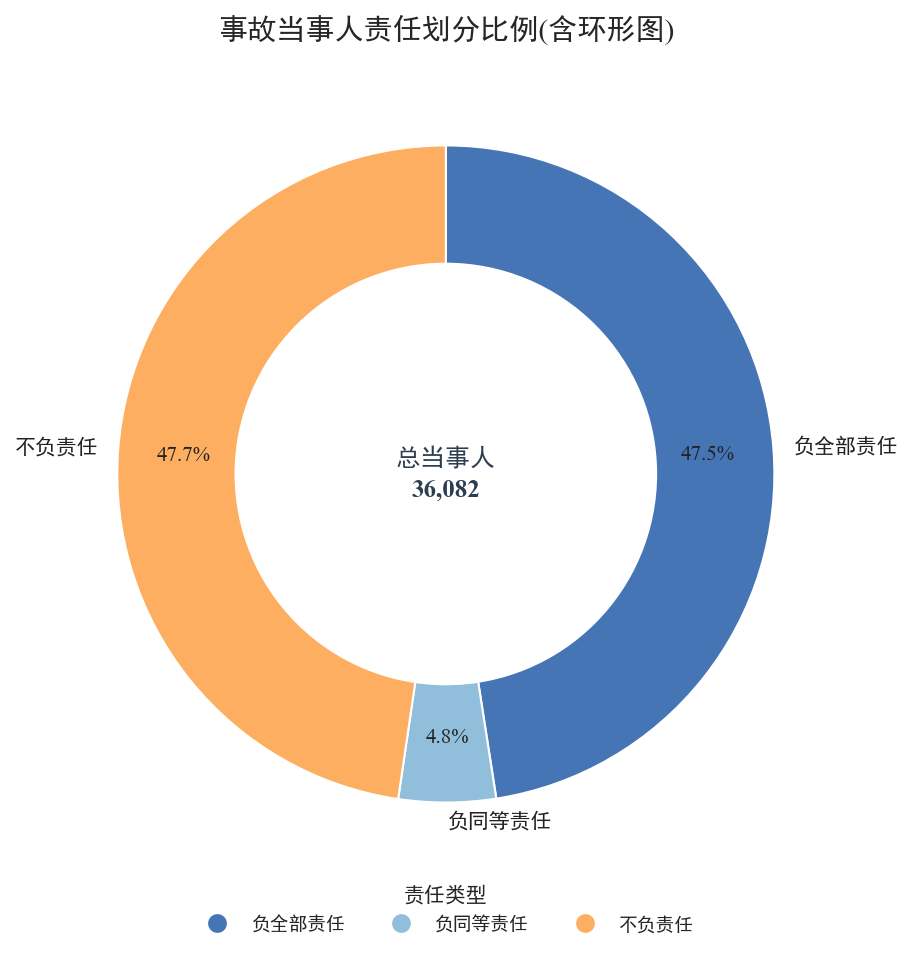

In [11]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib as mpl

resp1 = accidents['driver1responsibility'].astype(str)
resp2 = accidents['driver2responsibility'].astype(str)
resp_all = pd.concat([resp1, resp2], axis=0, ignore_index=True)#纵向合并两部分数据
resp_all = resp_all[resp_all.isin(['负全部责任', '负同等责任', '不负责任'])] #筛选有效责任类别
dist = resp_all.value_counts() #计算各责任类别频次
dist = dist.reindex(['负全部责任', '负同等责任', '不负责任']).fillna(0)
total = int(dist.sum())
pct = (dist / total * 100).round(2)
dist_1 = resp1.value_counts().reindex(['负全部责任', '负同等责任', '不负责任']).fillna(0)
dist_2 = resp2.value_counts().reindex(['负全部责任', '负同等责任', '不负责任']).fillna(0)
pct_1 = (dist_1 / dist_1.sum() * 100).round(2)
pct_2 = (dist_2 / dist_2.sum() * 100).round(2)

# 冷蓝色:代表主要责任
# 浅蓝色:代表同等责任
#暖橙色:代表无责任(突出显示)

total_parties = resp_all.shape[0] #计算总当事人数量(用于环形图中心文本显示)

autopct='%1.1f%%',
startangle=90
counterclock=False,
colors=colors,
pctdistance=0.80,
labeldistance=1.06,
textprops={'fontsize': 10, 'color': '#222'}

palette = {
    '负全部责任':'#4575b4',
    '负同等责任':'#91bfdb',
    '不负责任':'#fdae61'
}

colors =[palette[k] for k in dist.index] #按责任类型顺序生成颜色列表

# 创建画布和子图(环形图适合正方形画布)
fig, ax = plt.subplots(figsize=(6.8,6.8)) #画布大小为6.8x6.8英寸

# 绘制饼图(后续将处理为环形)
weges, texts, autotexts = ax.pie(
    dist.values, #饼图数据:各责任类型的数量
    labels=[f'{k}'for k in dist.index],#每个扇形的标签,责任类型名称
    autopct='%1.1f%%', #自动计算并显示百分比,格式为1位小数
    startangle=90, #从正上方开始绘制饼图
    counterclock=False, #顺时针方向绘制
    colors=colors, #扇形颜色:对应责任类型的配色
    pctdistance=0.80, #百分比标签距离圆心的相对位置
    labeldistance=1.06, #标签距离圆心的相对位置
    textprops={'fontsize': 10, 'color': '#222'} #文本属性:字体10号,深灰色

)

# 环形效果:在饼图中心添如白色圆形覆盖,形成环形
centre_circle = plt.Circle((0,0), 0.64,fc='white') #创建一个白色圆形(圆心(0,0),半径0.64,填充白色)
ax.add_artist(centre_circle)#将白色圆形添加到子图中,覆盖饼图中心区域形成环形

# 在环形中心添加当事人数量文本
ax.text(
0, 0, #文本位置:圆心处
f"总当事人\n{total_parties:,}",
ha='center', va='center',
fontsize=12, weight='bold',color='#2c3e50', linespacing=1.5 #字体12号,加粗,深青灰色,行问距1.5

# 文本内容:“总当事人”+换行+带千分位的总事故数
# 水平和垂直方向均居中对齐

)

#自定义图例(避免自动图例可能下出现“无标签”的警告)
handles=[plt.Line2D( #创建自定义图例元素(用圆形标记代表颜色)
[0],[0],marker='o',color='w',#隐藏线条,仅显示标记
label=lab,#图例标签:责任类型
markerfacecolor=palette[lab], #标记颜色:对应责任类型的配色
markersize=10 #标记大小
)for lab in dist.index] #遍历所有责任类型生成图例元素

# 设置图例位置和样式
ax.legend(
handles=handles,#使用自定义图例元素
title='责任类型',#图例标题
ncol=3,#图例分3列显示
loc='lower center',#图例位置:下方居中
bbox_to_anchor=(0.5,-0.08),#调整图例位置(相对于子图的坐标偏移)
frameon=False,#去除图例边框
fontsize=9 # 图例字体9号
)
ax.set_title(
'事故当事人责任划分比例(含环形图)', fontsize=14, pad=12
)#图表标题:明确展示内容,字体14号,与顶部间距12
plt.tight_layout(rect=[0,0.05,1,1]) #调整布局,预留底部空间给图例
plt.show()

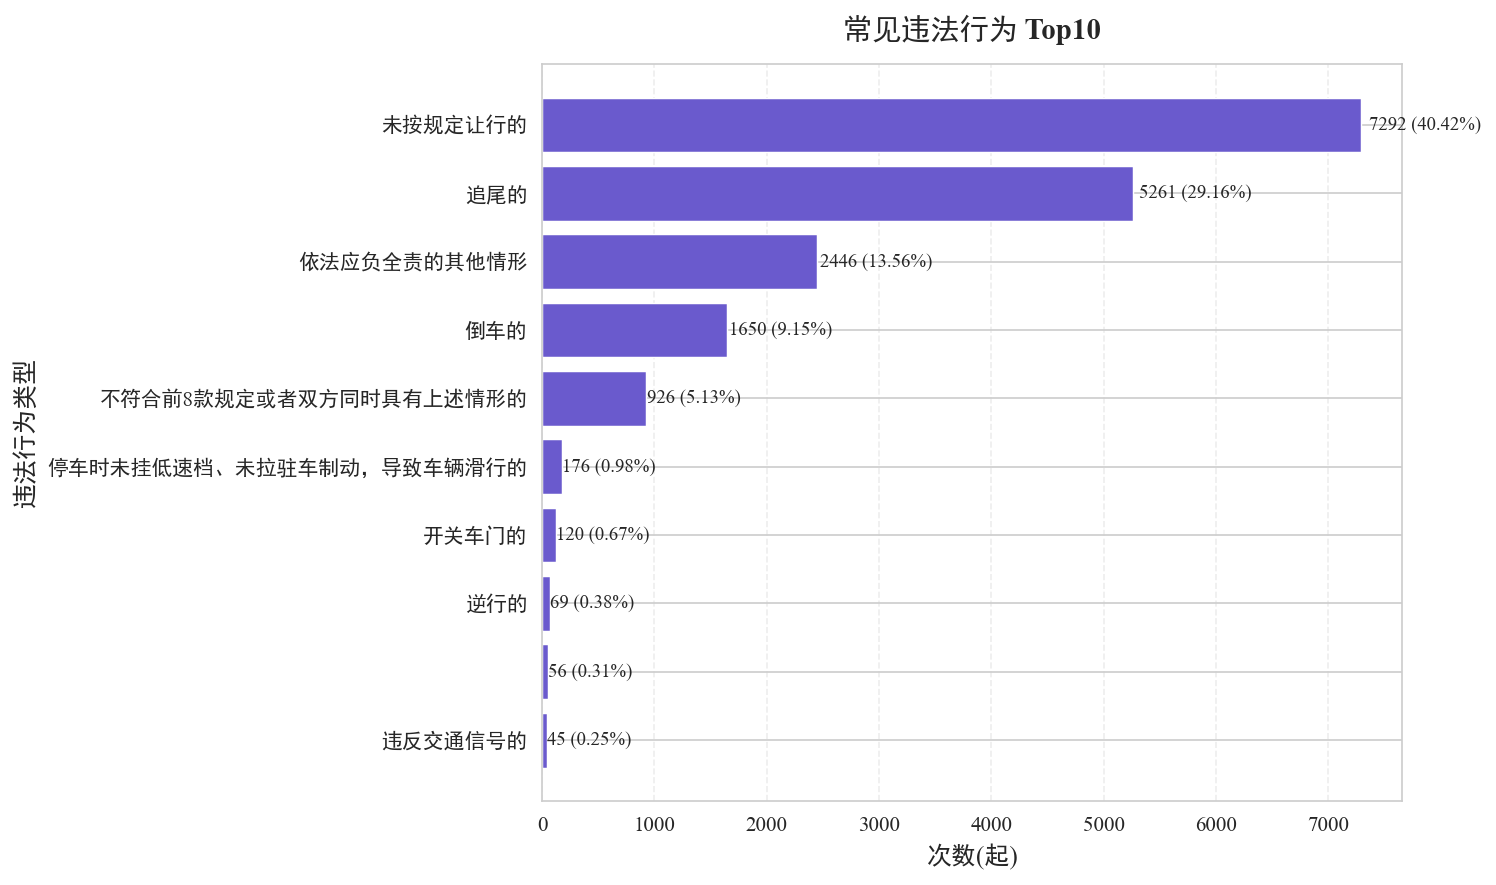

In [25]:
import re #正则表达式库,用于字符串处理


fault_series = accidents['driver1fault'].astype(str).str.strip()
fault_series = fault_series.apply(
    # r前缀
    #\d匹配数字
    #+表示匹配前面的元素一次或多次
    #、直接匹配点号
    #re.sub用于替换字符串中匹配的部分
    lambda x: re.sub(r'^\d+、', '', x).strip() #去除开头的编号和点号
)
fault_series = fault_series.fillna('其他违法行为') #填充缺失值
# print(fault_series.head(10))
fault_counts = fault_series.value_counts().head(10)
total_faults = fault_counts.sum() #计算前10类故障的总次数
fault_pct = (fault_counts/total_faults * 100).round(2) #计算百分比并保留两位小数
fig, ax = plt.subplots(figsize=(10, 6))
# print(fault_counts)
bars = ax.barh( #创建水平条形图
    fault_counts.index[::-1], #反转索引顺序,使最高频率在顶部
    fault_counts.values[::-1], #反转值顺序,对应索引顺序
    color='#6A5ACD',
    linewidth=0.7,
    edgecolor='white'
)

#在条形末端添加次数和百分比标注
for bar, cnt, pct in zip(bars, fault_counts.values[::-1], fault_pct.values[::-1]):
    ax.text(
        cnt * 1.01, bar.get_y() + bar.get_height()/2,
        f'{cnt} ({pct:.2f}%)',
        ha='left', va='center', fontsize=9
    )
#图表美化
ax.set_title('常见违法行为 Top10', fontsize=14, pad=12, weight='bold')
ax.set_xlabel('次数(起)', fontsize=12)
ax.set_ylabel('违法行为类型', fontsize=12)
ax.grid(axis='x', linestyle='--', alpha=0.35)
plt.tight_layout()#自动调整布局
plt.show()

#### set_xticks和set_xticklabels
- `set_xticks`：用于设置x轴刻度的位置。
- `set_xticklabels`：用于设置x轴刻度的标签文本。
- 这两个方法通常结合使用，以确保刻度位置和标签文本一致。


[['未按规定让行的', 7292], ['追尾的', 5261], ['依法应负全责的其他情形', 2446], ['倒车的', 1650], ['不符合前8款规定或者双方同时具有上述情形的', 926], ['停车时未挂低速档、未拉驻车制动，导致车辆滑行的', 176], ['开关车门的', 120], ['逆行的', 69], ['', 56], ['违反交通信号的', 45]]


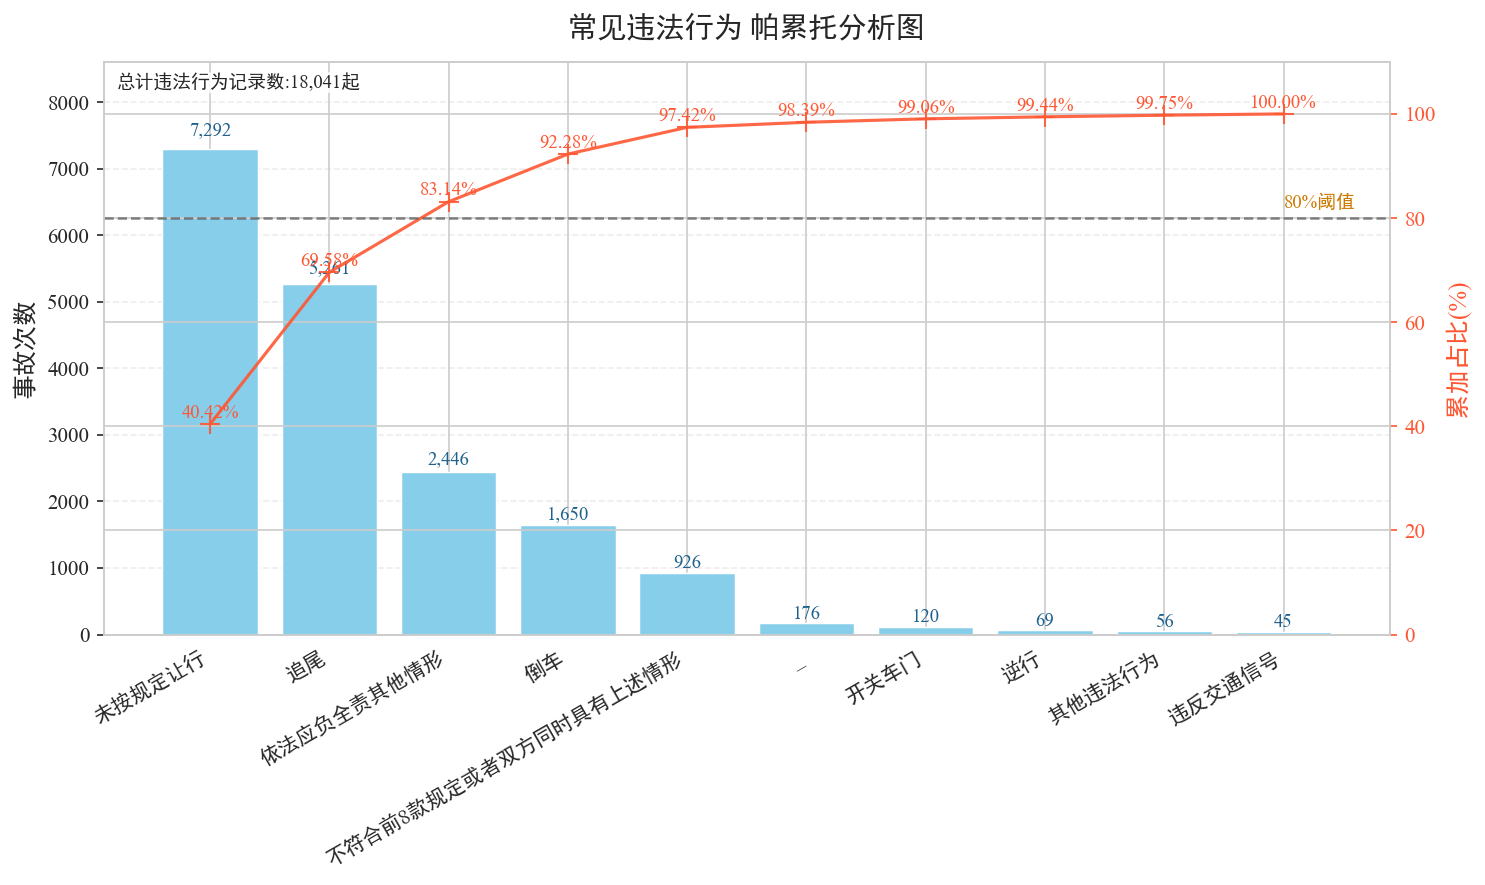

In [50]:

pairs = fault_counts.reset_index().values.tolist()
print(pairs)
df = pd.DataFrame(pairs, columns=['fault', 'count'])
df['fault'] = df['fault'].apply(lambda x: '其他违法行为' if x == '' else x)
df['fault'] = df['fault'].str.replace('的', '', regex=True)
df = df.sort_values('count', ascending=False).reset_index(drop=True)
total = int(df['count'].sum())
df['pct'] = df['count'] / total * 100
df['cum_pct'] = df['pct'].cumsum() #计算累计百分比

# 绘制帕累托图
fig, ax = plt.subplots(figsize=(10, 6)) #创建画布和子图,大小为10x6英寸
bars = ax.bar(
    df.index, #x轴数据:违法行为类型
    df['count'], #y轴数据:对应次数
    color='#87CEEB',
    edgecolor='white',
    linewidth=0.7
)
ax.set_ylabel('事故次数', fontsize=12)
ax.set_ylim(0, df['count'].max() * 1.18)
ax.grid(axis='y', linestyle='--', alpha=0.35)
xticklabels = [shorten(s, width=20, placeholder='_') for s in df['fault']]#阶段过长的标签过长使用缩略显示
ax.set_xticks(df.index)
ax.set_xticklabels(xticklabels, rotation=30, fontsize=10, ha='right') #旋转30度，右对齐

#在子图顶部标注具体的事故次数
#enumerate用于同时获取索引和值
for _, (x, v) in enumerate(zip(df.index, df['count'])): #遍历每个条形的x位置和高度
    ax.text(
        x, v * 1.02,
        f'{v:,}',
        ha='center', va='bottom', fontsize=9, color='#1f618d'
    )
ax2 = ax.twinx() #创建共享x轴的第二个y轴
ax2.plot(
    df.index, df['cum_pct'],
    color='#FF5733',
    marker='+', #数据点标记:园形除了圆还有+
    markersize=10,
    lw=1.5,
    alpha=0.9
)
ax2.set_ylabel('累加占比(%)', fontsize=12, color='#FF5733')
#tick_params用于设置坐标轴刻度线和标签的属性
ax2.tick_params(axis='y', colors='#FF5733') #右y轴颜色和折线一致
ax2.set_ylim(0, 110) #设置右y轴范围为0-110%
for x, v in zip(df.index, df['cum_pct']):
    ax2.text(
        x, v+1.2,
        f'{v:.2f}%',
        ha='center', color='#FF5733', fontsize=9
    )
ax2.axhline(
    80, color='#555555', linestyle='--', linewidth=1.2, alpha=0.7
)
ax2.text(
    len(df)-0.4, 80 + 1.2,
    '80%阈值',
    color='#cc7a00', fontsize=9, ha='right', va='bottom',
)
ax.set_title(
    '常见违法行为 帕累托分析图',
    fontsize=14, pad=12, weight='bold'
)
ax.text(
    0.01, 0.98, #相对子图的比例坐标(左边缘1%, 上边缘2%)
    f'总计违法行为记录数:{total:,}起', #文本内容:总违法行为记录数(千分位)
    transform=ax.transAxes, ha='left', va='top', fontsize=9, #transform=ax.transAxes告诉其适用相对坐标器不使用坐标器
    bbox=dict(boxstyle='round,pad=0.05', facecolor='white', alpha=.85, lw=0) 
)
plt.tight_layout() #自动调整布局避免重叠
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib as mpl

data = pd.read_csv(r'D:/python_demo/coding/data/guiyang2015tianqishuju.csv', encoding='gbk')
# print(data.dtypes)
data['日期'] = pd.to_datetime(data['日期'],format='%Y年%m月%d日', errors='coerce')
def day_night(hour):
    if 6 <= hour < 18:
        return '白天'
    else:
        return '夜间'
data['时段'] = data['日期'].dt.hour.apply(day_night)
data

,日期,天气状况,气温,风力风向,时段
0,2015-01-01,阴 /阴,8℃ / 6℃,东北风 ≤3级 /南风 ≤3级,夜间
1,2015-01-02,多云 /多云,12℃ / 6℃,南风 ≤3级 /南风 ≤3级,夜间
2,2015-01-03,多云 /多云,13℃ / 7℃,南风 ≤3级 /南风 ≤3级,夜间
3,2015-01-04,多云 /阴,13℃ / 7℃,东北风 ≤3级 /东南风 ≤3级,夜间
4,2015-01-05,小雨 /小雨,11℃ / 3℃,东南风 ≤3级 /东北风 ≤3级,夜间


In [89]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib as mpl
import sys
data = pd.read_csv(r'D:/python_demo/coding/data/accid1.csv', encoding='gbk')
print(data.columns)

p1 = ['accidenttime', 'accidentaddr', 'driver1fault', 'driver1responsibility','sex1', 'platenumber1', 'carcolor1','jxmc1','cclzrq1','clpp1','driver1license','brith1']
p2 = ['accidenttime', 'accidentaddr', 'driver1fault', 'driver2responsibility','sex2', 'platenumber2', 'carcolor2','jxmc2','cclzrq2','clpp2','driver2license','brith2']

accidents_1 = data[p1].copy()
accidents_2 = data[p2].copy()
new_columns = ['accidenttime', 'accidentaddr', 'driverfault', 'driverresponsibility','sex', 'platenumber', 'carcolor','jxmc','cclzrq','clpp','driverlicense','brith']
new_columns = ['事故时间', '事故地点', '驾驶员违法行为', '驾驶员责任划分','性别', '车牌号', '车辆颜色','车辆类型','初次领证日期','车辆品牌','驾驶证号','出生日期']
accidents_1.columns = new_columns
accidents_2.columns = new_columns
accidents_1.head()
new_accidents = pd.concat([accidents_1, accidents_2], axis=0, ignore_index=True)
# new_accidents.to_csv(r'D:/python_demo/coding/data/accidents_full.csv', index=False, encoding='utf-8-sig')

Index(['accidenttime', 'accidentaddr', 'driver1fault', 'driver1responsibility',
       'driver2responsibility', 'sex1', 'platenumber1', 'carcolor1', 'sex2',
       'platenumber2', 'carcolor2', 'jxmc1', 'jxmc2', 'cclzrq1', 'cclzrq2',
       'clpp1', 'clpp2', 'driver1license', 'driver2license', 'brith1',
       'brith2'],
      dtype='object')


In [95]:
# data = pd.read_csv(r'D:/python_demo/coding/data/accidents_full.csv', encoding='bgk')
data = new_accidents.copy()
print(data.head())
data.reset_index(inplace=True, drop=True)
data['驾驶员责任划分'].unique()



            事故时间    事故地点                  驾驶员违法行为 驾驶员责任划分  性别      车牌号 车辆颜色  \
0  2015/2/4 8:23  花溪大道北段               7、未按规定让行的    负全部责任   1  贵AVG423   白色   
1  2015/2/4 8:40  花溪区孟关乡                    3、倒车的   负全部责任   1  贵AKC352   白色   
2  2015/2/4 7:20    白金大道                    1、追尾的   负全部责任   1  贵A24876    蓝   
3  2015/2/4 9:20      金阳               7、未按规定让行的    负全部责任   1  贵A7287L    黑   
4  2015/2/4 9:00     新华路  9、不符合前8款规定或者双方同时具有上述情形的   负同等责任   1  贵AU1522   白色   

   车辆类型           初次领证日期 车辆品牌                 驾驶证号    出生日期  
0    -1               -1  朗逸牌   36455619349666600   985082  
1    -1               -1  长安牌  354664000000000000   196904  
2  鑫鑫驾校  2006/11/30 0:00  华神牌  366364000000000000   196907  
3  消防驾校   2004/6/17 0:00  众泰牌  366068000000000000   197512  
4    自培   2006/1/23 0:00  大众牌  366577000000000000   197209  


array(['负全部责任', '负同等责任', '不负责任'], dtype=object)

In [ ]:
data['驾驶员违法行为'].value_counts(dropna=False).head(10)
data.drop(data[data['驾驶员违法行为']== ''].index, inplace=True)



In [98]:
import re
data['出生日期'] = data['出生日期'].apply(
    lambda x: x[:4] if re.findall(r'^19[4-9]\d', str(x)) else np.nan

)
data['出生日期']

0         NaN
1        1969
2        1969
3        1975
4        1972
         ... 
36077    1982
36078    1980
36079    1957
36080    1964
36081    1972
Name: 出生日期, Length: 36082, dtype: object

车辆颜色处理

In [ ]:
#去除前后空格
data['车辆颜色'] = data['车辆颜色'].str.strip()
color_map = {
    '白': '白色', '白色': '白色', ' 白': '白色', '白色 ': '白色', 'BAI': '白色',
    '蓝': '蓝色', '兰': '蓝色', '蓝色': '蓝色', '兰 ': '蓝色',
    '黑': '黑色', '黑色': '黑色', ' 黑': '黑色', '黑色 ': '黑色',
    '红': '红色', '红色': '红色', ' 红': '红色', '红 ': '红色',
    '灰': '灰色', '灰色': '灰色',
    '银': '银色', '银色': '银色', ' 银': '银色', '银 ': '银色', 'Y银': '银色',
    '黄': '黄色', '黄色': '黄色', '黄 ': '黄色',
    '绿': '绿色', '绿色': '绿色', '绿 ': '绿色',
    '棕': '棕色'
}
#映射标准颜色
data['车辆颜色'] = data['车辆颜色'].map(color_map) 
#删除无效异常值
invalid_terms = ['小型', '客车', '货车', '猴哥', '拔丝', '表示', '北', '小轿车']
data = data[~data['车辆颜色'].isin(invalid_terms)]

,事故时间,事故地点,驾驶员违法行为,驾驶员责任划分,性别,车牌号,车辆颜色,车辆类型,初次领证日期,车辆品牌,驾驶证号,出生日期
0,2015/2/4 8:23,花溪大道北段,7、未按规定让行的,负全部责任,1,贵AVG423,白色,-1,-1,朗逸牌,36455619349666600,NaN
1,2015/2/4 8:40,花溪区孟关乡,3、倒车的,负全部责任,1,贵AKC352,白色,-1,-1,长安牌,354664000000000000,1969
2,2015/2/4 7:20,白金大道,1、追尾的,负全部责任,1,贵A24876,蓝色,鑫鑫驾校,2006/11/30 0:00,华神牌,366364000000000000,1969
3,2015/2/4 9:20,金阳,7、未按规定让行的,负全部责任,1,贵A7287L,黑色,消防驾校,2004/6/17 0:00,众泰牌,366068000000000000,1975
4,2015/2/4 9:00,新华路,9、不符合前8款规定或者双方同时具有上述情形的,负同等责任,1,贵AU1522,白色,自培,2006/1/23 0:00,大众牌,366577000000000000,1972
...,...,...,...,...,...,...,...,...,...,...,...,...
36077,2015/5/10 22:26,贵开路,7、未按规定让行的,负同等责任,1,贵CHT461,红色,自培,2014/11/5 0:00,北京现代牌,366564000000000000,1982
36078,2015/2/5 17:20,林城西路,7、未按规定让行的,不负责任,1,贵AAS408,蓝色,自培,2001/12/31 0:00,银钢牌,366361000000000000,1980
36079,2015/4/16 12:30,金珠大道,1、追尾的,不负责任,1,贵A67R99,红色,自培,2014/2/17 0:00,北京现代牌,364548000000000000,1957
36080,2015/2/12 13:01,蟠桃宫,7、未按规定让行的,不负责任,0,贵JDN385,黑色,自培,2000/12/27 0:00,东风标致牌,366667000000000000,1964
